# Machine Learning Pong

In [127]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('./data/game_log.csv')

## EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Ball Trajectory Visualization

This plot illustrates the trajectory of a ball based on its X and Y coordinates over time, as recorded in the `df` DataFrame.

- The main trajectory is drawn using a smooth line (`dodgerblue`) to show the ball's path.
- The starting point of the trajectory is highlighted with a green marker for visual reference.
- The Y-axis is inverted to match typical game screen coordinates, where the origin is at the top-left corner.
- Grid lines are enabled for better spatial interpretation, and a legend is included for clarity.

This visualization helps analyze movement patterns, detect anomalies, or debug gameplay mechanics.

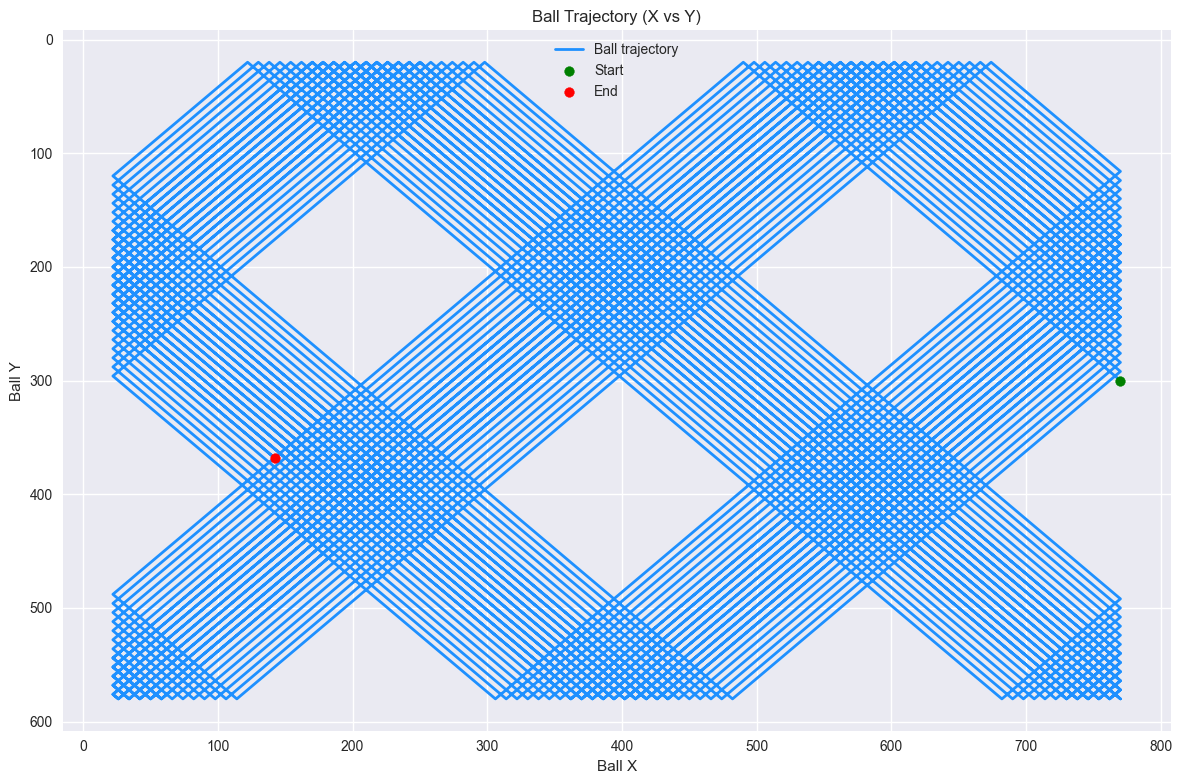

In [141]:
# Plot ball trajectory
fig, ax = plt.subplots(figsize=(12, 8))

# Plot trajectory
ax.plot(df['ball_x'], df['ball_y'], label='Ball trajectory', color='dodgerblue', linewidth=2)

# Optional: mark start and end points
ax.scatter(df['ball_x'].iloc[0], df['ball_y'].iloc[0], color='green', label='Start', zorder=5)
ax.scatter(df['ball_x'].iloc[-1], df['ball_y'].iloc[-1], color='red', label='End', zorder=5)

# Labels and styling
ax.set_xlabel('Ball X')
ax.set_ylabel('Ball Y')
ax.set_title('Ball Trajectory (X vs Y)')
ax.grid(True)
ax.legend()
ax.invert_yaxis()  # Match game screen coordinates

plt.tight_layout()
plt.show()

### Paddle Position Over Time

This plot visualizes the vertical position of the paddle (`paddle_y`) across sequential frames in a gameplay dataset. It provides insight into how the paddle moves over time, which can be useful for analyzing player behavior, AI control logic, or collision dynamics.

**Key Features:**
- The paddle's position is plotted in **orange** for clear visibility.
- The **Y-axis is inverted** to match typical game screen coordinates, where the origin is at the top-left.
- **Grid lines** are enabled to aid visual tracking of movement.
- **Plot spines** (borders) are removed for a cleaner, distraction-free presentation.
- A **legend** is included to label the trajectory.

This visualization helps identify patterns such as paddle responsiveness, idle periods, or abrupt movements that may indicate collisions or control changes.

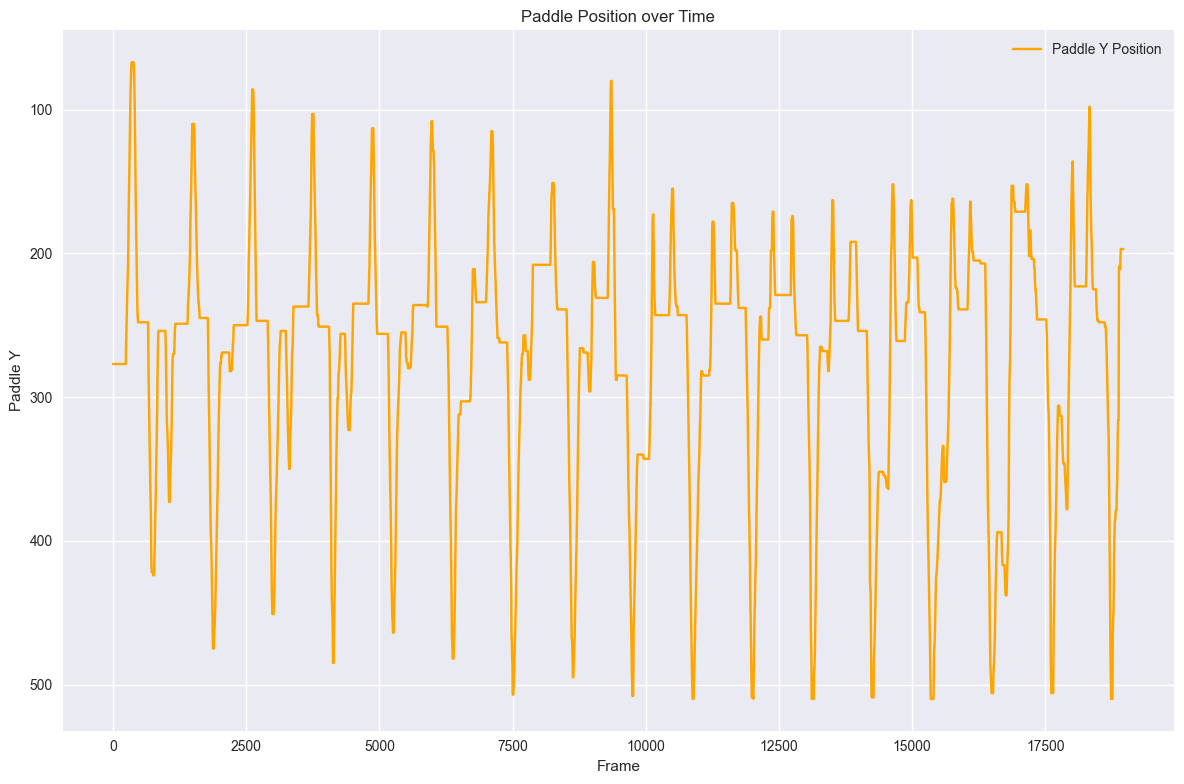

In [139]:
# Plot paddle position over time

fig, ax = plt.subplots(figsize=(12, 8))

# Plot paddle position
ax.plot(df['paddle_y'], label='Paddle Y Position', color='orange')

# Labels and styling
ax.set_title('Paddle Position over Time')
ax.set_xlabel('Frame')
ax.set_ylabel('Paddle Y')
ax.invert_yaxis()  # Match game screen coordinates
ax.grid(True)
ax.legend()

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

### Feature Correlation Heatmap

This visualization displays a heatmap of pairwise correlations between features in the dataset `df`. It helps identify relationships between variables, which is especially useful for feature selection, multicollinearity detection, and exploratory data analysis.

**Key Elements:**
- `df.corr().round(2)` computes the Pearson correlation coefficients and rounds them to two decimal places for readability.
- A **mask** is applied to hide the upper triangle of the symmetric matrix, reducing visual redundancy.
- The `PiYG` colormap highlights both positive and negative correlations with contrasting colors.
- `annot=True` overlays the exact correlation values on each cell.
- `sns.set_theme(style="white")` ensures a clean background for better contrast.

This heatmap provides a quick overview of how features interact with one another, guiding decisions in model building and data preprocessing.

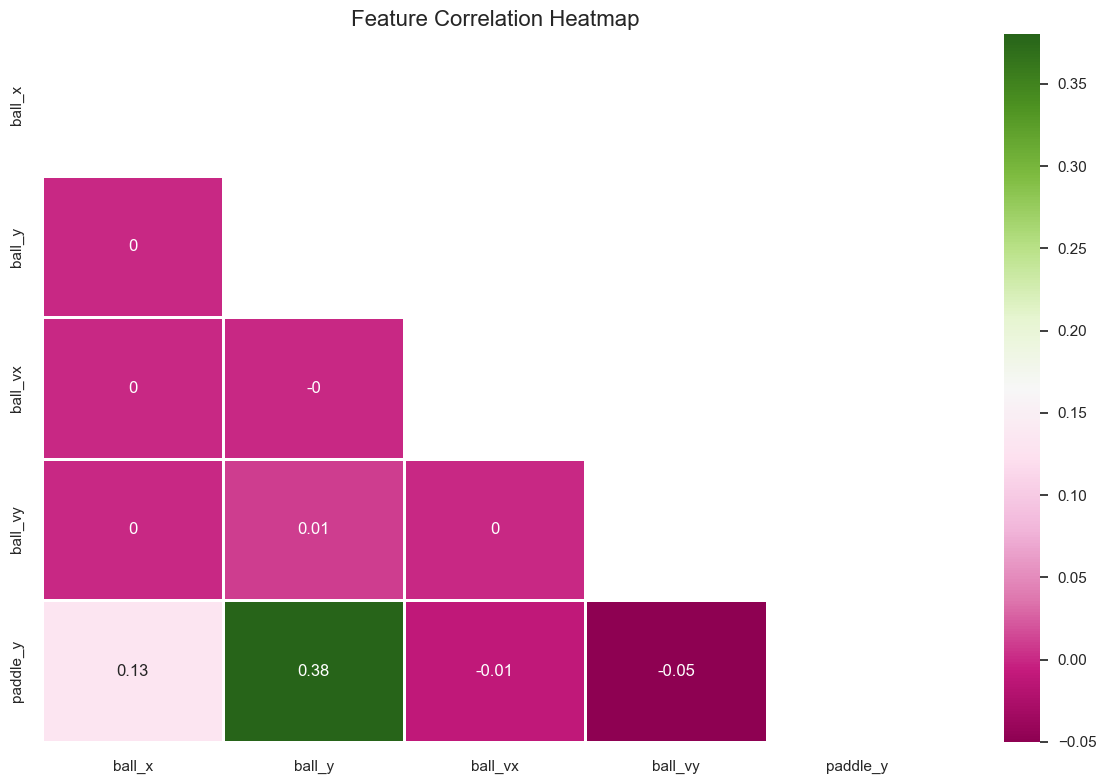

In [131]:
# Correlation heatmap
sns.set_theme(style="white")
corr = df.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='PiYG', linewidths=2, mask=mask)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [77]:
df.head()

,ball_x,ball_y,ball_vx,ball_vy,paddle_y
0,770,300,-4,-4,277
1,766,296,-4,-4,277
2,762,292,-4,-4,277
3,758,288,-4,-4,277
4,754,284,-4,-4,277


In [78]:
df.shape

(18968, 5)

In [79]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ball_x,18968.0,396.492408,216.709626,22.0,210.0,398.0,586.0,770.0
ball_y,18968.0,299.050822,161.606442,20.0,160.0,296.0,440.0,580.0
ball_vx,18968.0,-0.043863,3.999865,-4.0,-4.0,-4.0,4.0,4.0
ball_vy,18968.0,0.005061,4.000102,-4.0,-4.0,4.0,4.0,4.0
paddle_y,18968.0,272.238138,84.313023,67.0,231.0,250.0,303.0,510.0


In [80]:
df.dropna(inplace=True)

In [81]:
X = df[['ball_x', 'ball_y', 'ball_vx', 'ball_vy']].values  # Features
y = df['paddle_y']  # Target

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model training and evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


### Regression Model Evaluation Pipeline

This code snippet builds and evaluates four different regression models using scikit-learn pipelines and hyperparameter tuning. The goal is to compare model performance based on Mean Squared Error (MSE) and R² score.

#### Models Included:
1. **Linear Regression**  
   - Baseline model with no hyperparameter tuning.
   - Includes feature scaling via `StandardScaler`.

2. **Polynomial Regression**  
   - Combines polynomial feature expansion with linear regression.
   - Uses `GridSearchCV` to tune the polynomial degree (`[12, 16, 20]`).
   - Pipeline ensures consistent preprocessing and modeling.

3. **K-Nearest Neighbors (KNN) Regression**  
   - Uses `GridSearchCV` to tune number of neighbors and weighting strategy.
   - Pipeline includes scaling and model fitting.

4. **Random Forest Regression**  
   - Ensemble model with hyperparameter tuning for number of trees and max depth.
   - Pipeline includes scaling and model fitting.

#### Evaluation Metrics:
- **Mean Squared Error (MSE)**: Measures average squared difference between predicted and actual values. Lower is better.
- **R² Score**: Indicates how well the model explains variance in the target variable. Higher is better.

Each model is trained on `X_train`, evaluated on `X_test`, and its performance is stored in the `results` dictionary. The final output prints a summary of each model’s MSE and R² score, allowing for easy comparison.

This pipeline provides a robust framework for benchmarking regression models and selecting the best-performing approach.

In [95]:
# Store results
results = {}

In [96]:
# 1. Linear Regression (no hyperparameters to tune, but included for completeness)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'R2': r2_score(y_test, y_pred_lr)
}

In [97]:
# 2. Polynomial Regression + Linear Regression
poly_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('lr', LinearRegression())
])
poly_params = {
    'poly__degree': [12, 16, 20]
}
grid_poly = GridSearchCV(poly_pipeline, poly_params, cv=5, verbose=3, n_jobs=-1)
grid_poly.fit(X_train, y_train)
y_pred_poly = grid_poly.predict(X_test)
results[f'Polynomial Regression (deg={grid_poly.best_params_["poly__degree"]})'] = {
    'MSE': mean_squared_error(y_test, y_pred_poly),
    'R2': r2_score(y_test, y_pred_poly)
}

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [98]:
# 3. KNN Regression
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])
knn_params = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(knn_pipeline, knn_params, cv=5, verbose=3, n_jobs=-1)
grid_knn.fit(X_train, y_train)
y_pred_knn = grid_knn.predict(X_test)
results[f'KNN Regression (best={grid_knn.best_params_})'] = {
    'MSE': mean_squared_error(y_test, y_pred_knn),
    'R2': r2_score(y_test, y_pred_knn)
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [99]:
# 4. Random Forest Regression
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])
rf_params = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30]
}
grid_rf = GridSearchCV(rf_pipeline, rf_params, cv=5, verbose=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
results[f'Random Forest Regression (best={grid_rf.best_params_})'] = {
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [100]:
# Display results
print("Model Evaluation Results:")
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.2f}, R² = {metrics['R2']:.2f}")

Model Evaluation Results:
Linear Regression: MSE = 5896.97, R² = 0.16
Polynomial Regression (deg=16): MSE = 525.60, R² = 0.93
KNN Regression (best={'knn__n_neighbors': 3, 'knn__weights': 'distance'}): MSE = 285.67, R² = 0.96
Random Forest Regression (best={'rf__max_depth': 20, 'rf__n_estimators': 200}): MSE = 598.00, R² = 0.92


### Model Performance Visualization: MSE and R² Comparison

This section visualizes the performance of multiple regression models using two key metrics:

- **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values. Lower values indicate better predictive accuracy.
- **R² Score**: Represents the proportion of variance in the target variable explained by the model. Higher values indicate better model fit.

#### Code Highlights:
- The `results` dictionary contains evaluation metrics for each model.
- Two bar charts are generated:
  - One for **MSE**, using a sky-blue color scheme.
  - One for **R²**, using a light-green color scheme.
- Each bar is labeled with its exact score (rounded to two decimal places) using the `add_labels()` function.
- Y-axis labels and ticks are removed for a cleaner visual presentation.
- Annotations are added to clarify the interpretation of each metric:
  - “Lower MSE is better”
  - “Higher R² is better”
- The charts use `seaborn-v0_8` styling for a polished aesthetic.

These visualizations provide a quick and intuitive comparison of model performance, helping identify which algorithm offers the best balance of accuracy and generalization.

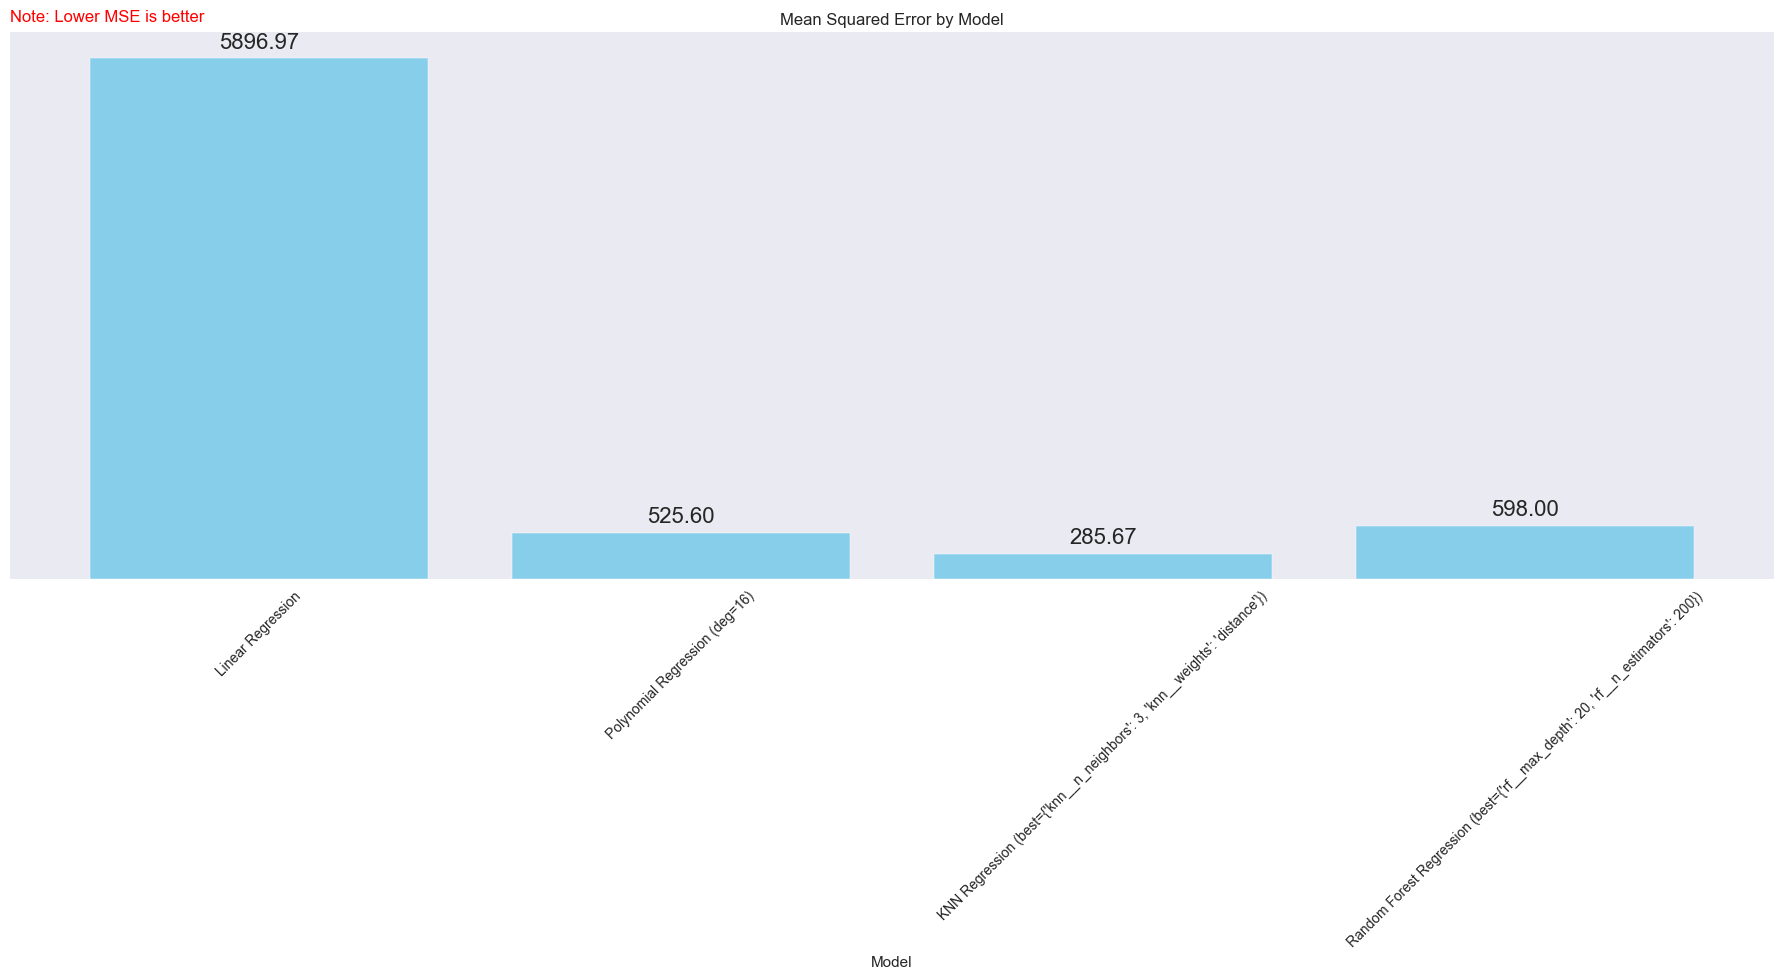

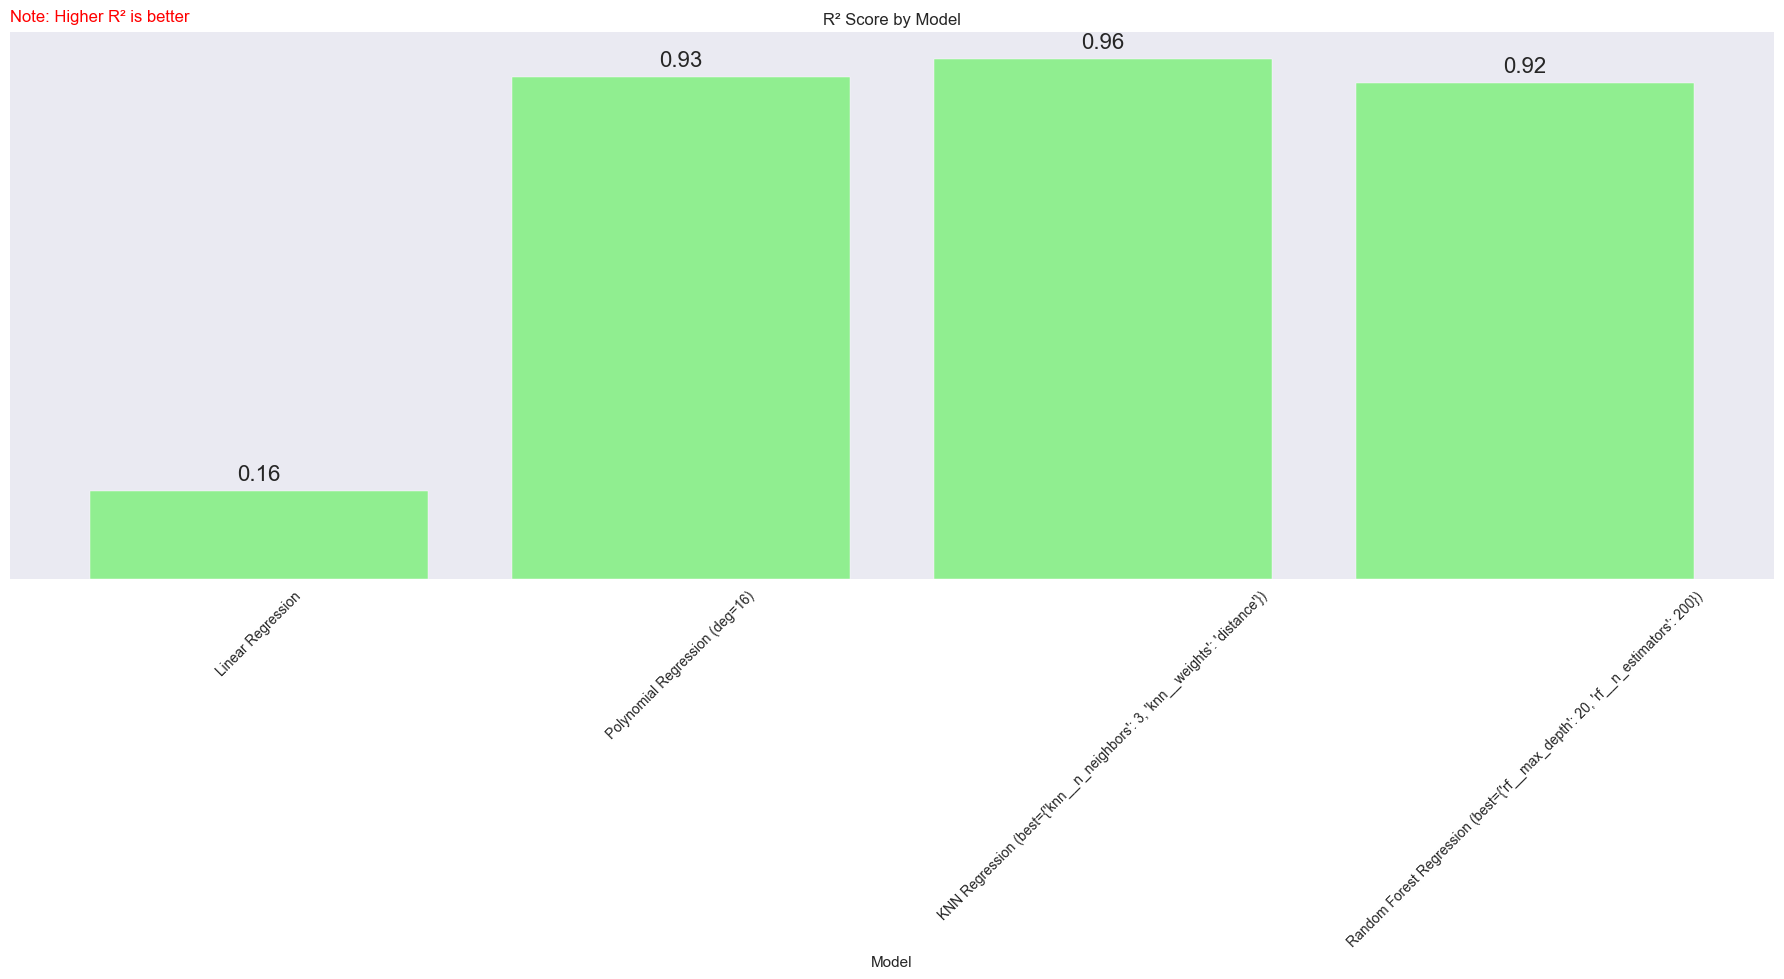

In [138]:
models = list(results.keys())
mse_scores = [results[model]['MSE'] for model in models]
r2_scores = [results[model]['R2'] for model in models]

# Function to add centered value labels
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i] + max(y) * 0.02, f'{y[i]:.2f}', ha='center', fontsize=16)
plt.style.use('seaborn-v0_8')

# Plot MSE
fig, ax = plt.subplots(figsize=(18, 10))
ax.grid(False)
bars = ax.bar(models, mse_scores, color='skyblue')
add_labels(models, mse_scores)

ax.set_title('Mean Squared Error by Model')
ax.set_xlabel('Model')
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='y', length=0)

# Add annotation
ax.text(0, 1.02, 'Note: Lower MSE is better', fontsize=12, color='red', transform=ax.transAxes)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot R²
fig, ax = plt.subplots(figsize=(18, 10))
ax.grid(False)
bars = ax.bar(models, r2_scores, color='lightgreen')
add_labels(models, r2_scores)

ax.set_title('R² Score by Model')
ax.set_xlabel('Model')
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='y', length=0)

# Add annotation
ax.text(0, 1.02, 'Note: Higher R² is better', fontsize=12, color='red', transform=ax.transAxes)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Final Model Retraining: KNN Regression

This code snippet retrains the best-performing model—**K-Nearest Neighbors (KNN) Regression**—on the **entire dataset** to prepare it for final deployment or prediction.

#### Key Steps:
- **Feature Scaling**:  
  The input features `X` are standardized using `StandardScaler` to ensure that all variables contribute equally to distance calculations in KNN.

- **Model Initialization**:  
  The `KNeighborsRegressor` is instantiated using the optimal hyperparameters (`n_neighbors` and `weights`) previously identified via `GridSearchCV`.

- **Model Training**:  
  The final model is trained on the scaled full dataset (`X_scaled`, `y`) to leverage all available data for maximum predictive power.

This step ensures that the final model reflects the best configuration and benefits from the full training data, making it ready for evaluation on unseen data or integration into a production pipeline.

In [ ]:
# Retraining the best model (KNN Regression) on the full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

final_model = KNeighborsRegressor(n_neighbors=grid_knn.best_params_['knn__n_neighbors'], weights=grid_knn.best_params_['knn__weights'])
final_model.fit(X_scaled, y)

,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## Saving and Verifying the Final Model

This code snippet demonstrates how to persist the trained machine learning model and its associated scaler using the `joblib` library. Saving these components allows for efficient reuse without retraining, which is especially useful in production environments or when deploying models.

#### Key Steps:
- **Saving the Model and Scaler**:  
  - `final_model` is saved to `./model/ml_model.pkl`  
  - `scaler` is saved to `./model/scaler.pkl`  
  These files can be loaded later to make predictions on new data using the same preprocessing and model configuration.

- **Verifying the Saved Model**:  
  - The model is reloaded using `joblib.load()`  
  - Its class name is printed to confirm successful serialization and deserialization.

This ensures that both the model and its preprocessing pipeline are preserved exactly as trained, enabling consistent and reliable inference.

In [ ]:
import joblib

# Save the final model and scaler
joblib.dump(final_model, './model/ml_model.pkl')
joblib.dump(scaler, './model/scaler.pkl')

['./model/scaler.pkl']

In [ ]:
# Verify the saved model
print(joblib.load('./model/ml_model.pkl').__class__.__name__)

KNeighborsRegressor
